# Introduction to Optimizing Model Prediction Project

Welcome to the guided project on optimizing machine learning models in Python! In this project, we will take a step-by-step approach to optimize a machine learning model using various techniques we've learned throughout the course. Unlike previous guided projects where we focused on constructing a single model, this time we will start with a reference model and iteratively improve it using optimization strategies.

Our task in this project is to predict the extent of fire damage to a forest. To achieve this, we'll work with the Forest Fires dataset sourced from the UCI Machine Learning Repository. This dataset contains valuable information about forest fires, meteorological data, and the resulting damage. By exploring and analyzing this data, we aim to build a predictive model that can accurately estimate the damage caused by fires based on various factors.

**Project Objectives:**
1. Implement techniques for optimizing machine learning models.
2. Utilize tools such as handling outliers, performing k-fold cross-validation, and applying regularization.
3. Improve the performance of a reference linear regression model through iterative optimization.

**Getting Started:**
Before diving into the optimization process, let's start by initializing our reference model. We'll follow these steps to set the groundwork for our optimization journey:

1. Import necessary libraries, including pandas, numpy, and the LinearRegression class.
2. Load the dataset using the read_csv() function in pandas and explore its columns and structure.
3. Understand the dataset features, target variable, and any potential formatting or missing data issues.
4. Define our reference model using the LinearRegression class, focusing on the "temp" and "wind" features to predict the "area" of fire damage.

Throughout this project, we'll apply various optimization techniques to enhance the predictive power of our model and gain insights into its performance. Let's get started on this exciting journey of optimizing machine learning models!

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
# Load in the insurance dataset from a specific file path
# Make sure to provide the correct file path to the "fires.csv" dataset
fires = pd.read_csv("fires.csv")

# Create a new DataFrame for the reference model by selecting columns "wind," "temp," and "area"
# Drop any rows with missing values in the selected columns
fires_reference = fires[["wind", "temp", "area"]].dropna()

# Extract the predictor variables ("wind" and "temp") for the reference model
reference_X = fires_reference[["wind", "temp"]]

# Instantiate a LinearRegression object for our reference model
reference = LinearRegression()


In [3]:
# Iterate through each column in the "fires" DataFrame
for col in fires.columns:
    # Count the number of missing values in the current column using pd.isna()
    num_na = sum(pd.isna(fires[col]))
    # Print the number of missing values for the current column
    print(f"The {col} column has {num_na} missing values.")


The Unnamed: 0 column has 0 missing values.
The X column has 0 missing values.
The Y column has 0 missing values.
The month column has 0 missing values.
The day column has 0 missing values.
The FFMC column has 48 missing values.
The DMC column has 21 missing values.
The DC column has 43 missing values.
The ISI column has 2 missing values.
The temp column has 21 missing values.
The RH column has 30 missing values.
The wind column has 35 missing values.
The rain column has 32 missing values.
The area column has 0 missing values.


## Data Processing
First, we'll convert the `month` column into a categorical feature. Instead of using the strings, we'll convert it into an indicator for the summer months in the northern hemisphere.

For the sake of completion, we'll impute all of the features so that we can have the biggest set to choose from for sequential feature selection. We'll go with K-nearest neighbors imputation since we expect area damage to be similar among similar fires.

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

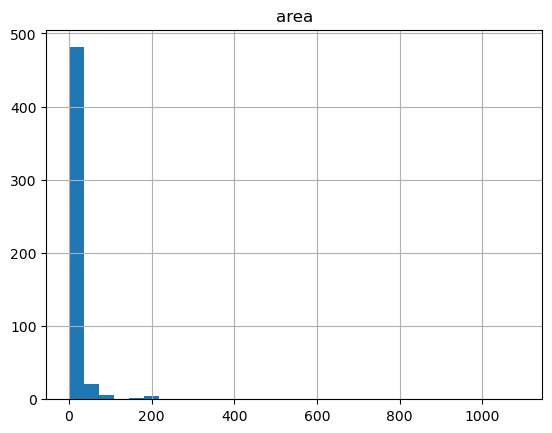

In [4]:
fires.hist("area", bins=30)

The outcome is highly right-skewed with extremely damaging fires. Furthermore, many of the rows have outcome values that are zero or near-zero. It might be worth it to log-transform the data. Note though that some of the outcomes are actually 0, so we can add 1 to prevent any errors. Recall that 
*log(0)* is undefined.

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

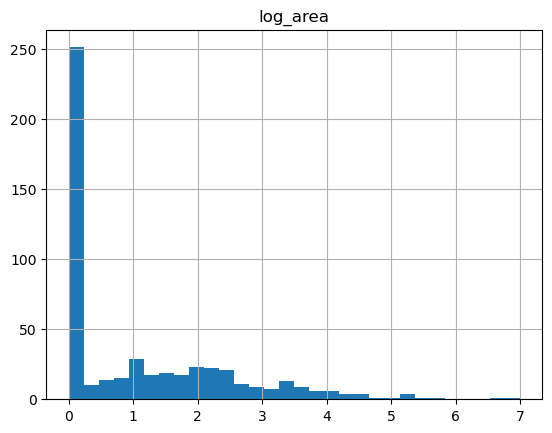

In [5]:
fires["log_area"] = np.log(fires["area"] + 1)

fires.hist("log_area", bins=30)

We can see that performing a log-transformation doesn't produce a bell-shaped distribution, but it does spread out the data a bit more than without the transformation. It's probably the case that most fires do not appreciably damage the forest, so we would be mistaken in removing all of these rows.

Instead of using month directly, we'll derive another feature called summer that takes a value of 1 when the fire occurred during the summer. The idea here is that summer months are typically hotter, so fires are more likely.

In [6]:
# Define a function to check if a given month is a summer month
def is_summer_month(month):
    # Check if the month is in the list of summer months ("jun", "jul", "aug")
    if month in ["jun", "jul", "aug"]:
        # Return 1 if the month is a summer month
        return 1
    else:
        # Return 0 if the month is not a summer month
        return 0

# Create a new column "summer" in the "fires" DataFrame using a list comprehension
# Apply the is_summer_month function to each value in the "month" column
fires["summer"] = [is_summer_month(m) for m in fires["month"]]


In [7]:
# Import the KNNImputer class from sklearn.impute
from sklearn.impute import KNNImputer

# Create a KNNImputer object with parameters for missing values and number of neighbors
imp = KNNImputer(missing_values=np.nan, n_neighbors=3)

# Select the columns containing missing values from the fires DataFrame (FFMC to rain)
fires_missing = fires[fires.columns[5:13]]

# Use the KNNImputer to impute missing values in the selected columns
# Fit the imputer and transform the missing values using the fit_transform() method
imputed = pd.DataFrame(imp.fit_transform(fires_missing), columns=fires.columns[5:13])

# Display the imputed DataFrame
imputed


,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


We'll examine the data for outliers using boxplots:

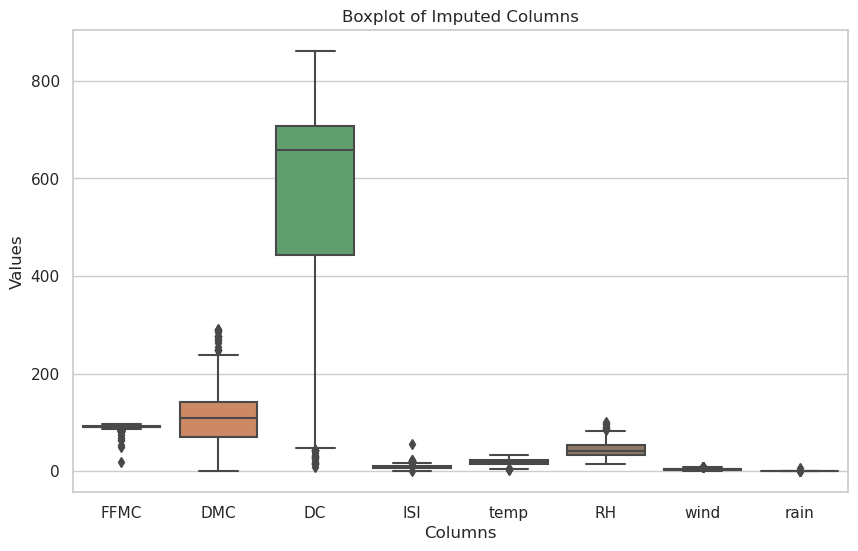

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style for seaborn
sns.set(style="whitegrid")

# Create a boxplot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=imputed[["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"]])

# Set the title and labels for the plot
plt.title("Boxplot of Imputed Columns")
plt.xlabel("Columns")
plt.ylabel("Values")

# Show the plot
plt.show()


The dots indicate that there are some outliers in the data. Let's examine the number of outliers in each of the columns.

In [10]:
# Iterate through each column in the 'imputed' DataFrame
for col in imputed.columns:
    # Calculate quartiles (25th, 50th, and 75th percentiles) for the current column
    quartiles = np.percentile(fires[col], [25, 50, 75])
    
    # Calculate the interquartile range (IQR) for the current column
    iqr = quartiles[2] - quartiles[0]
    
    # Calculate the lower and upper bounds for identifying outliers
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    
    # Count the number of outliers in the current column based on the boxplot method
    num_outliers = sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))
    
    # Print the number of outliers for the current column
    print(f"The {col} column has {num_outliers} outliers according to the boxplot method.")


The FFMC column has 0 outliers according to the boxplot method.
The DMC column has 0 outliers according to the boxplot method.
The DC column has 0 outliers according to the boxplot method.
The ISI column has 0 outliers according to the boxplot method.
The temp column has 0 outliers according to the boxplot method.
The RH column has 0 outliers according to the boxplot method.
The wind column has 0 outliers according to the boxplot method.
The rain column has 0 outliers according to the boxplot method.


Despite the visual cue in the boxplots, based on the actual calculations, there don't seem to be any outliers. In this case, we'll leave the dataset as-is.

Now that the dataset has been inspected for missing values and outliers, we can proceed to standardize it. These standardized values will help for standardization. Afterwards, we'll append the `summmer` feature back into the dataset.

In [12]:
# Import the StandardScaler class from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

# Instantiate a StandardScaler object
scaler = StandardScaler()

# Apply the standard scaling transformation to the 'imputed' DataFrame
scaled = scaler.fit_transform(imputed)

# Create a new DataFrame using the scaled values, with original column names
scaled = pd.DataFrame(scaled, columns=fires.columns[5:13])

# Concatenate the 'summer' column from the original 'fires' DataFrame with the scaled DataFrame
final = pd.concat([fires["summer"], scaled], axis=1)

# Display the final DataFrame containing the 'summer' column and scaled feature columns
final


,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...,...
512,1,-1.650265,-0.854803,0.495235,-1.563087,1.543370,-0.778581,-0.744573,-0.073268
513,1,-1.650265,-0.854803,0.495235,-1.563087,0.520585,1.679050,1.005944,-0.073268
514,1,-1.650265,-0.854803,0.495235,-1.563087,0.399238,1.616034,1.514159,-0.073268
515,1,0.681511,0.553912,0.286579,0.501683,1.161993,-0.148419,-0.010485,-0.073268


## Subset Selection

In [13]:
# Import the SequentialFeatureSelector class from sklearn.feature_selection
from sklearn.feature_selection import SequentialFeatureSelector

# Extract the target variable 'log_area'
y = fires["log_area"]

# Instantiate three LinearRegression models for feature selection with different numbers of features
sfs_model = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

# Instantiate three SequentialFeatureSelector objects with different numbers of features and directions
forward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="forward")

forward4 = SequentialFeatureSelector(estimator=sfs_model2,
                                     n_features_to_select=4, 
                                     direction="forward")

forward6 = SequentialFeatureSelector(estimator=sfs_model3,
                                     n_features_to_select=6, 
                                     direction="forward")

# Fit the SequentialFeatureSelector objects to the 'final' DataFrame and target variable 'y'
forward2.fit(final, y)
forward4.fit(final, y)
forward6.fit(final, y)

# Print the selected feature names for each model
print("Features selected in 2 feature model:", forward2.get_feature_names_out())
print("Features selected in 4 feature model:", forward4.get_feature_names_out())
print("Features selected in 6 feature model:", forward6.get_feature_names_out())


Features selected in 2 feature model: ['FFMC' 'DC']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [14]:
# Import the SequentialFeatureSelector class from sklearn.feature_selection
from sklearn.feature_selection import SequentialFeatureSelector

# Instantiate three LinearRegression models for feature selection with different numbers of features
sfs_model = LinearRegression()

# Instantiate three SequentialFeatureSelector objects with different numbers of features and directions
backward2 = SequentialFeatureSelector(estimator=sfs_model,
                                      n_features_to_select=2, 
                                      direction="backward")

backward4 = SequentialFeatureSelector(estimator=sfs_model,
                                      n_features_to_select=4, 
                                      direction="backward")

backward6 = SequentialFeatureSelector(estimator=sfs_model,
                                      n_features_to_select=6, 
                                      direction="backward")

# Fit the SequentialFeatureSelector objects to the 'final' DataFrame and target variable 'y'
backward2.fit(final, y)
backward4.fit(final, y)
backward6.fit(final, y)

# Print the selected feature names for each model
print("Features selected in 2 feature model:", backward2.get_feature_names_out())
print("Features selected in 4 feature model:", backward4.get_feature_names_out())
print("Features selected in 6 feature model:", backward6.get_feature_names_out())


Features selected in 2 feature model: ['DC' 'wind']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


Based on the features chosen by forward and backward selection, it seems like `DC`, `wind` and `FFMC` seem to be the most impactful on predicting `log_area`.

In [15]:
# Import the LinearRegression class from sklearn.linear_model
from sklearn.linear_model import LinearRegression

# Instantiate LinearRegression models for each combination of selected features
fw2_model = LinearRegression()  # Forward selection with 2 features
fw4_model = LinearRegression()  # Forward selection with 4 features
fw6_model = LinearRegression()  # Forward selection with 6 features

bw2_model = LinearRegression()  # Backward selection with 2 features
bw4_model = LinearRegression()  # Backward selection with 4 features
bw6_model = LinearRegression()  # Backward selection with 6 features

# Uncomment and use .fit() to train each model on the selected features
# fw2_model.fit(final[forward2.get_feature_names_out()], y)
# fw4_model.fit(final[forward4.get_feature_names_out()], y)
# fw6_model.fit(final[forward6.get_feature_names_out()], y)
# bw2_model.fit(final[backward2.get_feature_names_out()], y)
# bw4_model.fit(final[backward4.get_feature_names_out()], y)
# bw6_model.fit(final[backward6.get_feature_names_out()], y)


## More Candidate Models
Another approach we might consider taking is using regularized versions of linear regression. Fires have many factors that can increase the damaage they have, so it seems unhelpful to restrict our model to a univariate, non-linear model. There are such models; however, they were beyond the scope of the course, but they might be plausible candidates for further next steps.

In [17]:
# Import LassoCV and RidgeCV classes from sklearn.linear_model
from sklearn.linear_model import LassoCV, RidgeCV

# Create RidgeCV and LassoCV instances with specified alphas
ridge = RidgeCV(alphas=np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas=np.linspace(1, 10000, num=1000))

# Fit the RidgeCV and LassoCV models to the final feature matrix and target variable 'y'
ridge.fit(final, y)
lasso.fit(final, y)

# Print the tuning parameter (alpha) selected by RidgeCV and LassoCV
print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

# Print the coefficients obtained by RidgeCV and LassoCV
print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)


Ridge tuning parameter:  1372.2342342342342
LASSO tuning parameter:  10000.0
Ridge coefficients:  [-0.01455017  0.01311215  0.02006457  0.02004741 -0.01073465  0.01297049
 -0.01489714  0.02670554  0.00816103]
LASSO coefficients:  [-0.  0.  0.  0. -0.  0. -0.  0.  0.]


The LASSO tuning parameter always seems to be on the extreme. Given that the outcome has many small values, it suggests that having no features at all is better than having any. We'll try to home in on a better tuning parameter value below by choosing a smaller range to pick from.

In [18]:
# Import RidgeCV class from sklearn.linear_model
from sklearn.linear_model import RidgeCV

# Create a RidgeCV instance with the specified alpha range
ridge = RidgeCV(alphas=np.linspace(1000, 1500, num=1000))

# Fit the RidgeCV model to the final feature matrix and target variable 'y'
ridge.fit(final, y)

# Print the selected tuning parameter (alpha) by RidgeCV
print("Ridge tuning parameter: ", ridge.alpha_)


Ridge tuning parameter:  1371.3713713713714


We'll use this value in k-fold cross-validation, rounded to the hundredths place. We'll use a ridge regression and choose not to use a LASSO model here since the regularization results aren't helpful.

## K-Fold Cross-Validation

In [19]:
# Import cross_val_score from sklearn.model_selection
from sklearn.model_selection import cross_val_score 

# Calculate cross-validation scores for the reference linear regression model
reference_cv = cross_val_score(reference, final[["wind", "temp"]], y, cv=5, scoring="neg_mean_squared_error")

# Calculate cross-validation scores for the forward stepwise models with different feature counts
fw2_cv = cross_val_score(fw2_model, final[forward2.get_feature_names_out()], y, cv=5, scoring="neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model, final[forward4.get_feature_names_out()], y, cv=5, scoring="neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model, final[forward6.get_feature_names_out()], y, cv=5, scoring="neg_mean_squared_error")

# Calculate cross-validation scores for the backward stepwise models with different feature counts
bw2_cv = cross_val_score(bw2_model, final[backward2.get_feature_names_out()], y, cv=5, scoring="neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model, final[backward4.get_feature_names_out()], y, cv=5, scoring="neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model, final[backward6.get_feature_names_out()], y, cv=5, scoring="neg_mean_squared_error")

# Calculate cross-validation scores for the RidgeCV model
ridge_cv = cross_val_score(ridge, final, y, cv=5, scoring="neg_mean_squared_error")


In [20]:
# Print the average test MSE and standard deviation for the reference model
print("Reference Model, Avg Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))

# Print the average test MSE and standard deviation for the Forward-2 model
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))

# Print the average test MSE and standard deviation for the Forward-4 model
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))

# Print the average test MSE and standard deviation for the Forward-6 model
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))

# Print the average test MSE and standard deviation for the Backward-2 model
print("Backward-2 Model, Avg Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv))

# Print the average test MSE and standard deviation for the Backward-4 model
print("Backward-4 Model, Avg Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))

# Print the average test MSE and standard deviation for the Backward-6 model
print("Backward-6 Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))

# Print the average test MSE and standard deviation for the Ridge model
print("Ridge Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))


Reference Model, Avg Test MSE:  -2.204650013004116  SD:  1.060040355378637
Forward-2 Model, Avg Test MSE:  -2.1735431721198535  SD:  1.0208083278697586
Forward-4 Model, Avg Test MSE:  -2.193528106772711  SD:  1.0004774710977677
Forward-6 Model, Avg Test MSE:  -2.2397225539348753  SD:  1.0123323877770343
Backward-2 Model, Avg Test MSE:  -2.173357302739327  SD:  1.0038109503795958
Backward-4 Model, Avg Test MSE:  -2.193528106772711  SD:  1.0004774710977677
Backward-6 Model, Avg Test MSE:  -2.2397225539348753  SD:  1.0123323877770343
Ridge Model, Avg Test MSE:  -2.2397225539348753  SD:  1.0123323877770343


Among our candidate models, the backward selection model using two features performs the best, with an average MSE of -2.17. However, note that this is on the log-scale, so this suggests that the predictions are off by a magnitude of about 2. On the surface, this suggests that the models overall are not good predictors.

However, this problem is known to be a difficult one. The extreme skew in the outcome hurts many of the assumptions needed by linear models. We hope that this showcases that machine learning is not a universal fix. Several problems have characteristics that make prediction difficult.